# Current hierarichy performance

In [296]:
from datetime import date
from highlight_text import fig_text
from functools import reduce, partial
from itertools import permutations
from scipy import stats
from scipy.stats import f_oneway

import os
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import bigframes.pandas as bpd
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='once')

%load_ext google.cloud.bigquery
bpd.options.bigquery.project = "dhh-ncr-stg"

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## Get data

In [232]:
%%bigquery df_current
SELECT * FROM `dhh-ncr-stg.patrick_doupe.current_cohort_vendor_base`
WHERE global_entity_id = 'TB_AE'
AND DATE(created_month) = '2025-07-01'

Query is running:   0%|          |

Downloading:   0%|          |

In [233]:
n_vendors = df_current.vendor_id.nunique()
n_rows = df_current.shape[0]

assert n_vendors == n_rows, f"The numbers of rows {n_rows} differs from the number of vendors {n_vendors}"

n_cohorts = df_current.cohort_id.nunique()
n_cohorts_lt5 = (df_current.groupby("cohort_id")['vendor_id'].nunique() < 5).sum() 
n_cohorts_eq1 = (df_current.groupby("cohort_id")['vendor_id'].nunique() ==1).sum() 

print(f"The number of cohorts is {n_cohorts}")
print(f"The number of cohorts with less than five vendors is is {n_cohorts_lt5}")
print(f"The number of cohorts with one vendor is {n_cohorts_eq1}")

The number of cohorts is 2684
The number of cohorts with less than five vendors is is 0
The number of cohorts with one vendor is 0


In [234]:
df_current.gmv = df_current.gmv.astype("float")

In [235]:
df_current.describe()

,cohort_id,gmv,customers,orders
count,27709.0,27709.000000,27709.0,27709.0
mean,85003.19315,292.547740,12.61619,19.328052
std,74612.047604,719.282601,32.413023,47.303899
min,874.0,0.000000,0.0,0.0
25%,66257.0,0.000000,0.0,0.0
50%,81737.0,47.620000,2.0,4.0
75%,102214.0,253.250000,11.0,17.0
max,2002626.0,13986.880000,727.0,980.0


In [352]:
df_current.groupby('cohort_id')['vendor_code'].nunique().sort_values(ascending=False)

cohort_id
70778    2422
82329     122
26704      76
72173      70
79490      61
         ... 
95211       5
95208       5
63954       5
65090       5
86035       5
Name: vendor_code, Length: 2684, dtype: int64

Let's get the multiple that defines the top 5% of the distribution

In [236]:
multiple_of_mean_top_five_pc = df_current.gmv.quantile(q=0.95) / df_current.gmv.mean()
print(f"The 95th quantile of vendor revenue is {round(multiple_of_mean_top_five_pc, 1)} times the mean")

The 95th quantile of vendor revenue is 4.8 times the mean


GMV is distributed by something of a power law

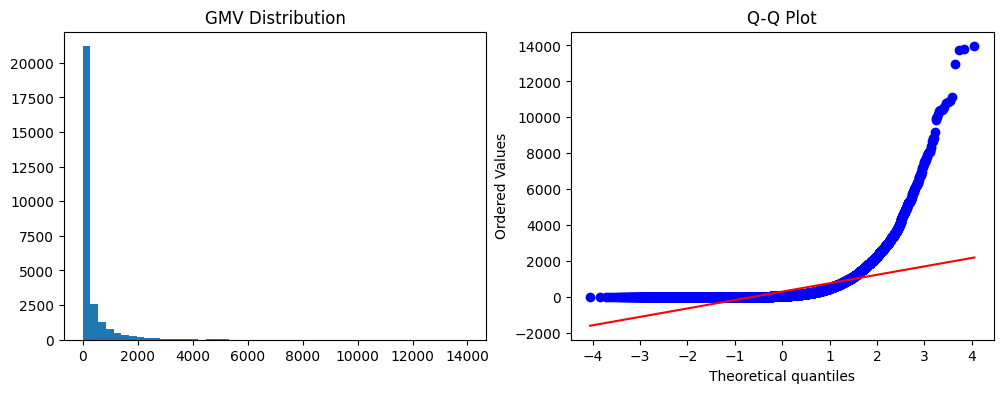

In [237]:
plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df_current['gmv'], bins=50)
plt.title(f'GMV Distribution')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df_current['gmv'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.show()

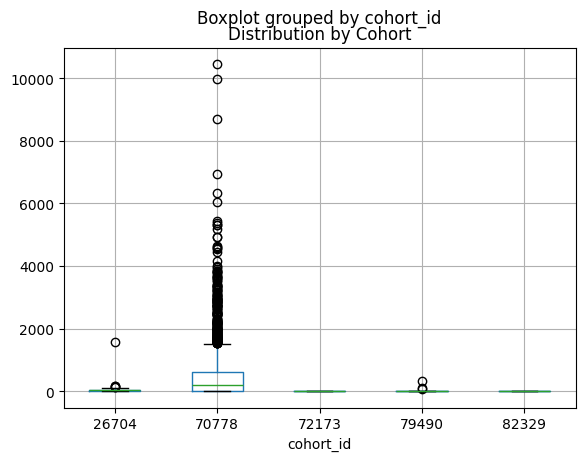

In [334]:
# Box plot by cohort (sample a few cohorts)
sample_cohorts = df_current['cohort_id'].value_counts().head(5).index
df_current[df_current['cohort_id'].isin(sample_cohorts)].boxplot(column='gmv', by='cohort_id')
plt.title('Distribution by Cohort')
plt.show()

Log GMV is a bit nicer, especially once you kill the no GMV

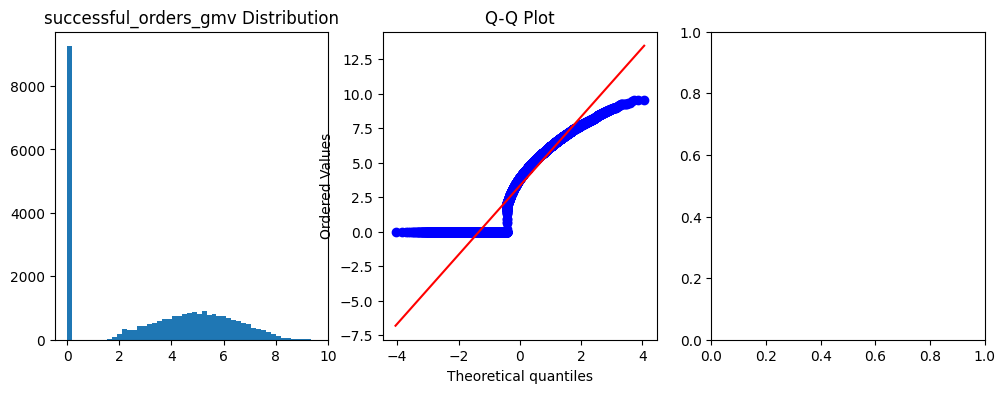

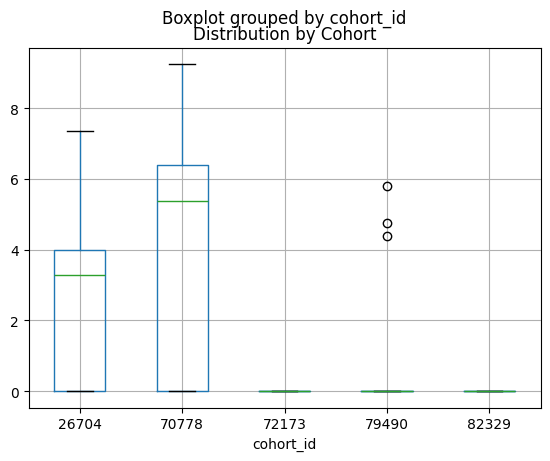

In [238]:
df_current['log_gmv'] = [np.log(1 + r) for r in df_current.gmv.values]

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 3, 1)
plt.hist(df_current['log_gmv'], bins=50)
plt.title(f'{'successful_orders_gmv'} Distribution')

# Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df_current['log_gmv'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Box plot by cohort (sample a few cohorts)
plt.subplot(1, 3, 3)
sample_cohorts = df_current['cohort_id'].value_counts().head(5).index
df_current[df_current['cohort_id'].isin(sample_cohorts)].boxplot(column='log_gmv', by='cohort_id')
plt.title('Distribution by Cohort')
plt.show()

For GMV, we have big outliers. The log-gmv distribution is far from normal. So we'll use the Kruskal-Wallis metric

In [239]:
from scipy.stats import kruskal, f_oneway
import numpy as np

def calculate_kruskal_wallis(df, performance_col, cohort_col):
    """
    Calculate Kruskal-Wallis H-statistic for cohort separation.
    
    Returns H-statistic (analogous to F-statistic) and p-value.
    """
    # Group data by cohorts
    cohort_groups = [group[performance_col].values 
                    for name, group in df.groupby(cohort_col) 
                    if len(group) >= 5]  # Skip tiny cohorts
    
    if len(cohort_groups) < 2:
        return np.nan, np.nan
    
    h_stat, p_value = kruskal(*cohort_groups)
    f_stat, _ = f_oneway(*cohort_groups)
    n = df.shape[0]
    epsilon_squared = h_stat / (n + 1)
    return h_stat, p_value, epsilon_squared, f_stat



In [240]:
## IQR method
def find_outliers_iqr(data, multiplier=3):
    """
    Standard: outliers beyond Q1 - 1.5*IQR or Q3 + 1.5*IQR
    Conservative: multiplier = 1.5
    Liberal: multiplier = 3.0
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Check outliers within each cohort
def flag_cohort_outliers(df, performance_col, cohort_col, multiplier=3):
    outlier_flags = []
    
    for cohort in df[cohort_col].unique():
        cohort_data = df[df[cohort_col] == cohort][performance_col]
        
        if len(cohort_data) >= 5:  # Need minimum size
            outliers = find_outliers_iqr(cohort_data, multiplier)
            outlier_flags.extend(outliers.values)
        else:
            outlier_flags.extend([False] * len(cohort_data))
    
    return outlier_flags

df_current['outlier_flag'] = flag_cohort_outliers(df_current, 'gmv', 'cohort_id')

In [241]:
num_outliers_IQR = df_current.outlier_flag.mean()
num_cohorts_with_outlier_IQR = df_current.groupby('cohort_id')['outlier_flag'].max().mean()

print(f"The share of vendors that are outliers in their cohort (IQR method) is {round(num_outliers_IQR, 2)}")
print(f"The share of cohorts with an outlier (IQR method) is {round(num_cohorts_with_outlier_IQR, 2)}")

The share of vendors that are outliers in their cohort (IQR method) is 0.04
The share of cohorts with an outlier (IQR method) is 0.28


In [242]:
def find_outliers_mean_multiple(data, multiplier=5):
    """
    Flag values that are X times larger than the mean
    multiplier=5 means values > 5 * mean are outliers
    """
    mean_value = data.mean()
    threshold = multiplier * mean_value
    outliers = data > threshold
    return outliers

def compare_outlier_methods(df, performance_col, cohort_col):
    """
    Compare different outlier detection methods
    """
    results = []
    
    for cohort in df[cohort_col].unique():
        cohort_data = df[df[cohort_col] == cohort][performance_col]
        
        if len(cohort_data) >= 5:  # Minimum size for meaningful comparison
            # Method 1: IQR (1.5x)
            iqr_outliers = find_outliers_iqr(cohort_data, multiplier=3)
            
            # Method 2: 5x Mean
            mean_outliers = find_outliers_mean_multiple(cohort_data, multiplier=5)
            
            # Method 3: MAD  
            # mad_outliers = find_outliers_mad(cohort_data, threshold=3.5)
            
            results.append({
                'cohort': cohort,
                'cohort_size': len(cohort_data),
                'mean': cohort_data.mean(),
                'median': cohort_data.median(),
                'iqr_outliers': iqr_outliers.sum(),
                'mean_5x_outliers': mean_outliers.sum(),
                # 'mad_outliers': mad_outliers.sum(),
                'iqr_pct': (iqr_outliers.sum() / len(cohort_data)) * 100,
                'mean_5x_pct': (mean_outliers.sum() / len(cohort_data)) * 100,
                'overlap_iqr_mean': (iqr_outliers & mean_outliers).sum()
            })
    
    return pd.DataFrame(results)


In [243]:
outlier_comparison = compare_outlier_methods(df_current, 'gmv', 'cohort_id')

# Calculate summary statistics
share_cohorts_with_outlier_IQR = np.mean([min(1, x) for x in outlier_comparison.iqr_outliers])
share_cohorts_with_outlier_5x = np.mean([min(1, x) for x in outlier_comparison.mean_5x_outliers])

iqr_total_outliers = outlier_comparison['iqr_outliers'].sum()
mean_5x_total_outliers = outlier_comparison['mean_5x_outliers'].sum()
overlap_total_vendors = outlier_comparison['overlap_iqr_mean'].sum()

h_stat, p_value, eps_sq, f_stat = calculate_kruskal_wallis(df_current, 'gmv', 'cohort_id')

In [244]:
print("--- Outlier Analysis Summary ---")
print(f"Share of cohorts with IQR outliers: {share_cohorts_with_outlier_IQR:.3f}")
print(f"Share of cohorts with 5x Mean outliers: {share_cohorts_with_outlier_5x:.3f}")
print(f"Total IQR outliers across all cohorts: {iqr_total_outliers}")
print(f"Total 5x Mean outliers across all cohorts: {mean_5x_total_outliers}")
print(f"Total vendors with overlap in IQR and 5x Mean outliers: {overlap_total_vendors}")
print("\n--- Kruskal-Wallis Test Results ---")
print(f"H-statistic: {h_stat:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Epsilon-squared (Effect Size): {eps_sq:.3f}")
print(f"F-statistic: {f_stat:.3f} (Note: F-stat typically from ANOVA, ensure source is correct)")

--- Outlier Analysis Summary ---
Share of cohorts with IQR outliers: 0.286
Share of cohorts with 5x Mean outliers: 0.149
Total IQR outliers across all cohorts: 1053
Total 5x Mean outliers across all cohorts: 544
Total vendors with overlap in IQR and 5x Mean outliers: 522

--- Kruskal-Wallis Test Results ---
H-statistic: 13624.550
P-value: 0.000
Epsilon-squared (Effect Size): 0.492
F-statistic: 11.276 (Note: F-stat typically from ANOVA, ensure source is correct)


# New datasets

`logistics-vendor.vg_success.smart_reco_vendor_cohorts`
`logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical`
`logistics-vendor-production.pa_staging.smart_reco_active_vendor_cohorts_combined`
`logistics-vendor-production.pa_staging.smart_reco_active_cohorts_original`
`logistics-vendor-production.pa_staging.smart_reco_active_cohorts_original_minimum_10_vendors`
`logistics-vendor-production.pa_staging.smart_reco_active_cohorts_chainless`
`logistics-vendor-production.pa_staging.smart_reco_active_cohorts_chainless_minimum_10_vendors`


In [248]:
%%bigquery df_best_match_basic
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1`
) where vendors>=5

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery df_best_match_hierarchical
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2`
) where vendors>=5


Query is running:   0%|          |

Downloading:   0%|          |

In [250]:
%%bigquery df_best_match_basic_no_cuisine
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_cuisine`
) where vendors>=5

Query is running:   0%|          |

Downloading:   0%|          |

In [389]:
%%bigquery df_best_match_hierarchical_no_cuisine
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2_cusine`
) where vendors>=5

Query is running:   0%|          |

Downloading:   0%|          |

In [252]:
%%bigquery df_min10
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_10`


) where vendors>=10

Query is running:   0%|          |

Downloading:   0%|          |

In [390]:
# getting both components of f-statistic


def calculate_anova_components(*samples):
    """
    Calculates the F-statistic, Mean Square Between (numerator), and
    Mean Square Within (denominator) for a one-way ANOVA.

    Args:
        *samples: Variable number of arrays, where each array represents
                  a group's data.

    Returns:
        tuple: A tuple containing:
            - f_statistic (float): The calculated F-statistic.
            - ms_between (float): The Mean Square Between (numerator).
            - ms_within (float): The Mean Square Within (denominator).
    """

    # 1. Calculate the Grand Mean
    all_observations = np.concatenate(samples)
    grand_mean = np.mean(all_observations)

    # Number of groups
    k = len(samples)

    # Total number of observations
    N = len(all_observations)

    # 2. Calculate Sum of Squares Between (SS_B)
    ss_between = 0
    for group in samples:
        n_j = len(group)  # Number of observations in current group
        mean_j = np.mean(group) # Mean of current group
        ss_between += n_j * (mean_j - grand_mean)**2

    # 3. Calculate Sum of Squares Within (SS_W)
    ss_within = 0
    for group in samples:
        mean_j = np.mean(group) # Mean of current group
        ss_within += np.sum((group - mean_j)**2)

    # 4. Calculate Degrees of Freedom
    df_between = k - 1
    df_within = N - k

    # Ensure degrees of freedom are valid to avoid division by zero
    if df_between == 0:
        raise ValueError("Cannot calculate MS_between with only one group.")
    if df_within == 0:
        raise ValueError("Cannot calculate MS_within with insufficient data (total observations equals number of groups).")

    # 5. Calculate Mean Square Between (MS_B)
    ms_between = ss_between / df_between

    # 6. Calculate Mean Square Within (MS_W)
    ms_within = ss_within / df_within

    # 7. Calculate the F-statistic
    f_statistic = ms_between / ms_within

    return f_statistic, ms_between, ms_within

def get_f_stat_components(df, performance_col, cohort_col):


    cohort_groups = [group[performance_col].values 
                    for name, group in df.groupby(cohort_col) 
                    if len(group) >= 5]  # Skip tiny cohorts
    
    if len(cohort_groups) < 2:
        return np.nan, np.nan
    
    f_stat, _ = f_oneway(*cohort_groups)

    # Calculate ANOVA components manually
    f_manual, ms_b_manual, ms_w_manual = calculate_anova_components(*cohort_groups)

    return {
        'f_scipy' : f_stat,
        'f_manual': f_manual,
        'ms_b_manual': ms_b_manual,
        'ms_w_manual': ms_w_manual
    }

In [391]:
def process_dataframes_for_outliers(dataframes_dict, value_column, group_column):
    """
    Loops through multiple DataFrames, performs outlier analysis, and compiles results
    into a single DataFrame.

    Args:
        dataframes_dict (dict): A dictionary where keys are DataFrame names (strings)
                                and values are the DataFrames themselves.
        value_column (str): The name of the column containing values for outlier detection.
        group_column (str): The name of the column used for grouping (e.g., 'cohort_id').

    Returns:
        pd.DataFrame: A DataFrame containing summary statistics for each input DataFrame.
    """
    results_df = pd.DataFrame(columns=[
        'df_name',
        'share_cohorts_with_outlier_IQR',
        'share_cohorts_with_outlier_5x',
        'iqr_total_outliers',
        'mean_5x_total_outliers',
        'overlap_total_vendors',
        'KW_H',
        'epsilon_squared',
        'p_value',
        'f_stat_scipy',
        'f_stat_manual',
        'ms_b_manual',
        'ms_w_manual'
    ])

    for df_name, df_tmp in dataframes_dict.items():
        print(f"Processing DataFrame: {df_name}...")
        outlier_comparison = compare_outlier_methods(df_tmp, value_column, group_column)

        components = get_f_stat_components(df_tmp, value_column, group_column)
        # Calculate summary statistics
        share_cohorts_with_outlier_IQR = np.mean([min(1, x) for x in outlier_comparison.iqr_outliers])
        share_cohorts_with_outlier_5x = np.mean([min(1, x) for x in outlier_comparison.mean_5x_outliers])

        iqr_total_outliers = outlier_comparison['iqr_outliers'].sum()
        mean_5x_total_outliers = outlier_comparison['mean_5x_outliers'].sum()
        overlap_total_vendors = outlier_comparison['overlap_iqr_mean'].sum()

        h_stat, p_value, eps_sq, f_stat = calculate_kruskal_wallis(df_tmp, value_column, group_column)

        # Append results to the DataFrame
        results_df = pd.concat([results_df, 
                                pd.DataFrame(
                                    [{'df_name': df_name,
                                      'share_cohorts_with_outlier_IQR': share_cohorts_with_outlier_IQR,
                                      'share_cohorts_with_outlier_5x': share_cohorts_with_outlier_5x,
                                      'iqr_total_outliers': iqr_total_outliers,
                                      'mean_5x_total_outliers': mean_5x_total_outliers, 
                                      'overlap_total_vendors': overlap_total_vendors, 
                                      'KW_H': h_stat,
                                      'epsilon_squared': eps_sq,
                                      'p_value': p_value,
                                      'f_stat': f_stat,
                                      'f_manual': components['f_manual']/1e6,
                                      'ms_b_manual': components['ms_b_manual']/1e6,
                                      'ms_w_manual': components['ms_w_manual']/1e6
                                      }])], 
                                ignore_index=True)
                                
    return results_df


In [392]:
df_current.rename(columns={'global_entity_id' : 'entity_id', 'vendor_id': 'vendor_code'}, inplace=True)
df_list = [df_min10, df_best_match_basic, df_best_match_hierarchical, 
           df_best_match_basic_no_cuisine, df_best_match_hierarchical_no_cuisine]
df_gmv = df_current[['entity_id', 'vendor_code', 'gmv']]

df_gmv_dict = {'current': df_current}
for name_, df_tmp in zip(['best_match_basic_min10', 'best_match_basic', 'hierarchical_basic', 'best_match_no_cuisine', 'hierarchical_no_cuisine'], df_list):
    tmp = pd.merge(df_tmp, df_gmv, on = ['entity_id', 'vendor_code'], how = 'left')
    tmp['gmv'] = tmp['gmv'].astype('float')
    tmp.fillna({'gmv': 0}, inplace=True)
    df_gmv_dict[name_] = tmp
    print(f"We lost {df_tmp.shape[0] - tmp.shape[0]} vendors")

print(f"We lost {df_gmv_dict['current'].shape[0] - tmp.shape[0]} vendors")

We lost 0 vendors
We lost 0 vendors
We lost 0 vendors
We lost 0 vendors
We lost 0 vendors
We lost -611 vendors


In [393]:
# Run the processing function
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    outlier_summary_results = process_dataframes_for_outliers(
        df_gmv_dict,
        'gmv',
        'cohort_id'
    )

Processing DataFrame: current...


/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1940389429.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,


Processing DataFrame: best_match_basic_min10...
Processing DataFrame: best_match_basic...
Processing DataFrame: hierarchical_basic...
Processing DataFrame: best_match_no_cuisine...
Processing DataFrame: hierarchical_no_cuisine...


In [394]:
outlier_summary_results

,df_name,share_cohorts_with_outlier_IQR,share_cohorts_with_outlier_5x,iqr_total_outliers,mean_5x_total_outliers,overlap_total_vendors,KW_H,epsilon_squared,p_value,f_stat_scipy,f_stat_manual,ms_b_manual,ms_w_manual,f_stat,f_manual
0,current,0.285768,0.148659,1053,544,522,13624.550059,0.491684,0.0,NaN,NaN,2.924127,0.259332,11.275609,0.000011
1,best_match_basic_min10,0.313008,0.261518,464,407,346,18103.527345,0.644322,0.0,NaN,NaN,13.069272,0.120159,108.766089,0.000109
2,best_match_basic,0.248656,0.142473,574,361,326,18501.525282,0.655223,0.0,NaN,NaN,7.074143,0.129515,54.620459,0.000055
3,hierarchical_basic,0.297932,0.172235,954,488,448,12457.759400,0.448314,0.0,NaN,NaN,1.962898,0.329413,5.958779,0.000006
4,best_match_no_cuisine,0.264865,0.177297,497,403,344,17808.250012,0.628778,0.0,NaN,NaN,11.533498,0.136144,84.715134,0.000085
5,hierarchical_no_cuisine,0.329644,0.237945,766,524,468,14888.467961,0.525704,0.0,NaN,NaN,5.867116,0.257355,22.797761,0.000023


In [395]:
outlier_summary_results.sort_values(by='df_name', inplace=True)

In [396]:
TABLE_ID = 'patrick_doupe.cohort_basic_hierarchy_statistics'
PROJECT_ID = 'dhh-ncr-stg'
pandas_gbq.to_gbq(outlier_summary_results, TABLE_ID, project_id=PROJECT_ID, if_exists='replace')

/Users/patrick.doupe/DH/ad_hoc/cohorts/.venv/lib/python3.13/site-packages/pandas_gbq/gbq_connector.py:461: PendingDeprecationWarning: In a future major release, the default delimiter will be changed to a `/` in accordance with RFC9110.
  user_agent = create_user_agent(

100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]


In [397]:
%%bigquery outlier_summary_results
SELECT * FROM `dhh-ncr-stg.patrick_doupe.cohort_basic_hierarchy_statistics`

Query is running:   0%|          |

Downloading:   0%|          |

In [398]:
def plot_figure_wrapper(y_val, y_label, title):

    plt.figure(figsize=(10, 6)) # Set the figure size for better readability

    # Create the bar plot using seaborn.barplot
    # x: column for the main groups (df_name)
    # y: column for the bar heights (Total Outliers)
    # hue: column for grouping within each x-category (Outlier Type)
    sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')

    # Add labels and title
    plt.xlabel('Cohort creation rule', fontsize=12) # X-axis label
    plt.xticks(rotation=45)
    plt.ylabel(y_label, fontsize=12) # Y-axis label
    plt.title(title, fontsize=14) # Plot title
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle horizontal grid
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show() # Display the plot
    return None

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1723580741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')


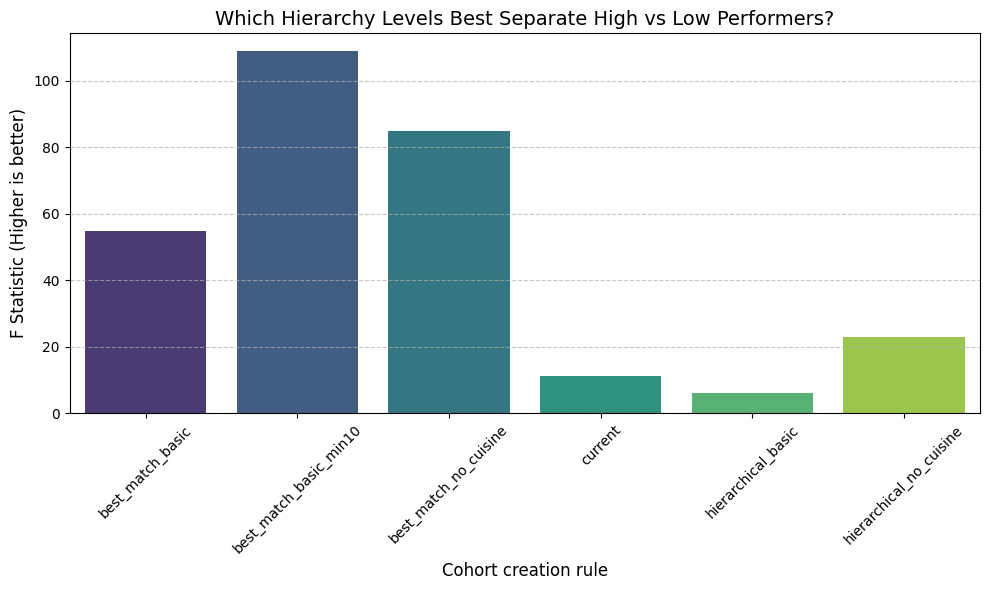

In [399]:
plot_figure_wrapper('f_stat', 'F Statistic (Higher is better)', 'Which Hierarchy Levels Best Separate High vs Low Performers?')

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1723580741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')


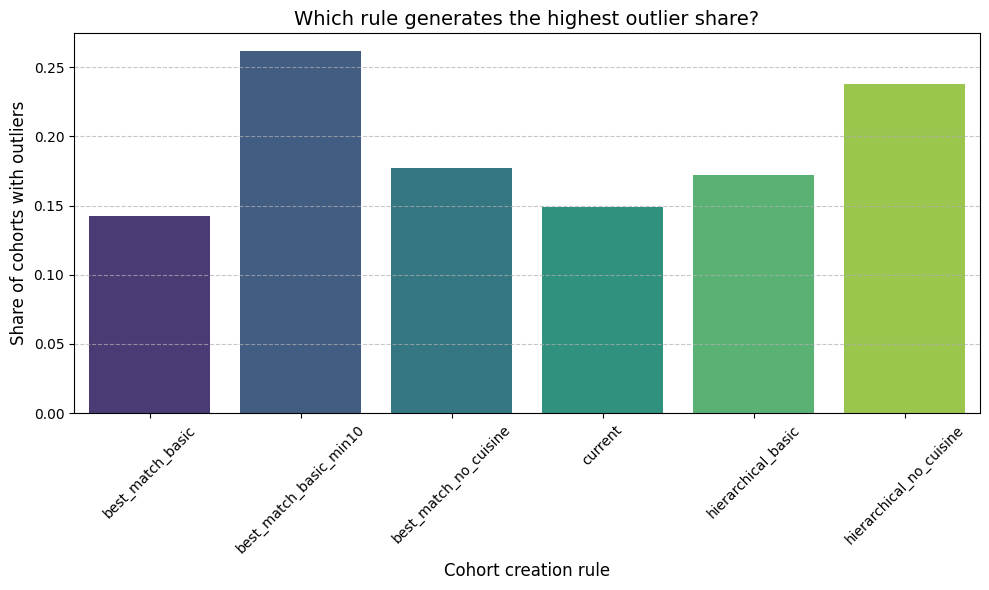

In [400]:
plot_figure_wrapper('share_cohorts_with_outlier_5x', 'Share of cohorts with outliers',
                    'Which rule generates the highest outlier share?')

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1723580741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')


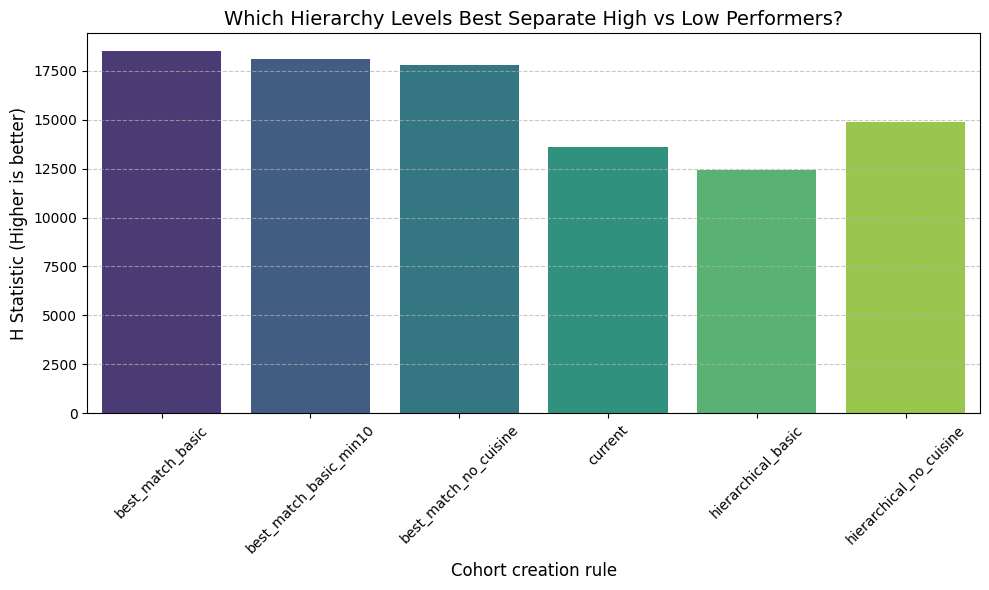

In [401]:
plot_figure_wrapper('KW_H', 'H Statistic (Higher is better)', 'Which Hierarchy Levels Best Separate High vs Low Performers?')

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1723580741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')


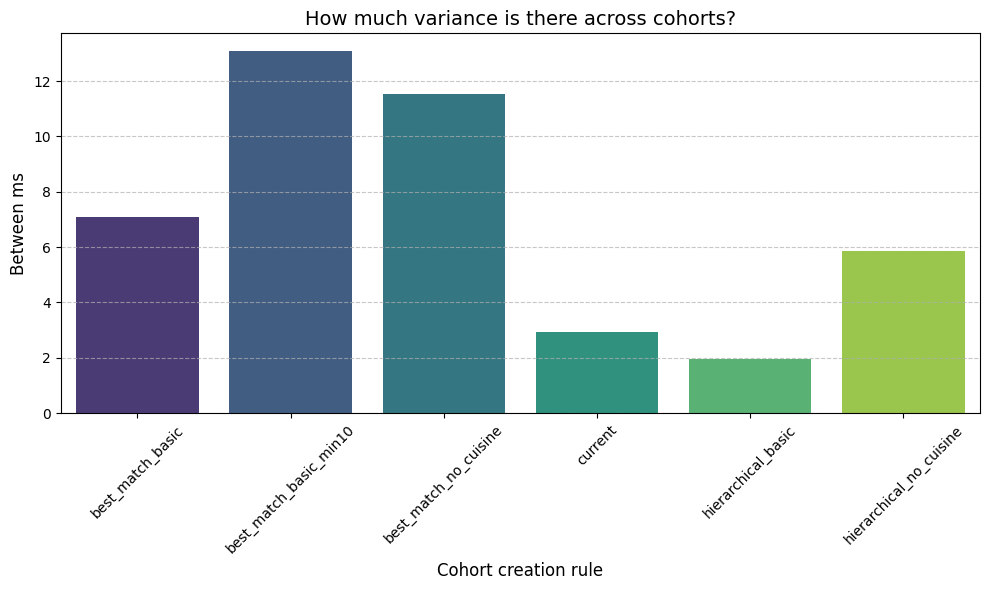

In [402]:
plot_figure_wrapper('ms_b_manual', 'Between ms', 'How much variance is there across cohorts?')

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_64289/1723580741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_summary_results, x='df_name', y=y_val, palette='viridis')


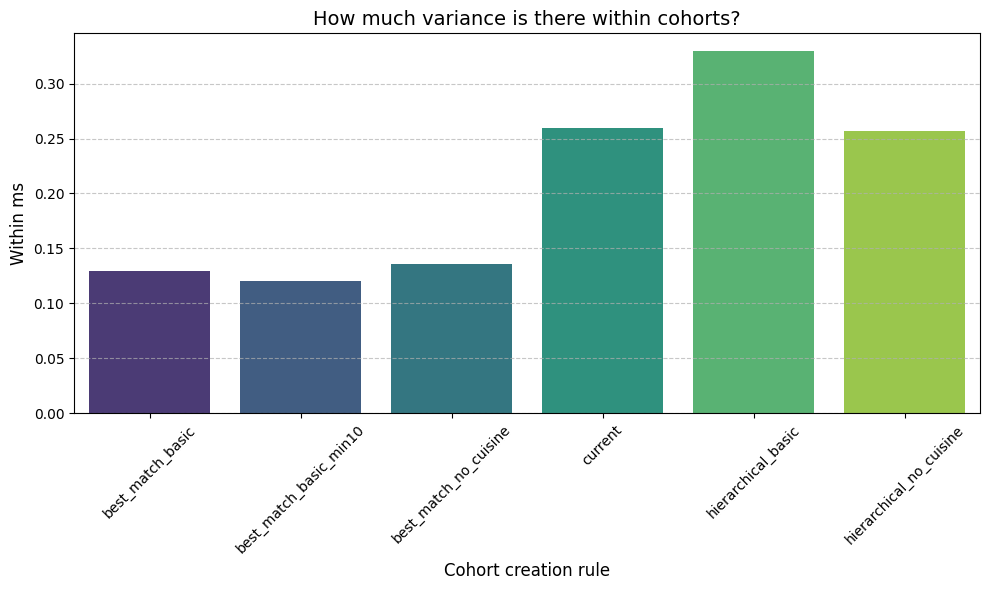

In [403]:
plot_figure_wrapper('ms_w_manual', 'Within ms', 'How much variance is there within cohorts?')

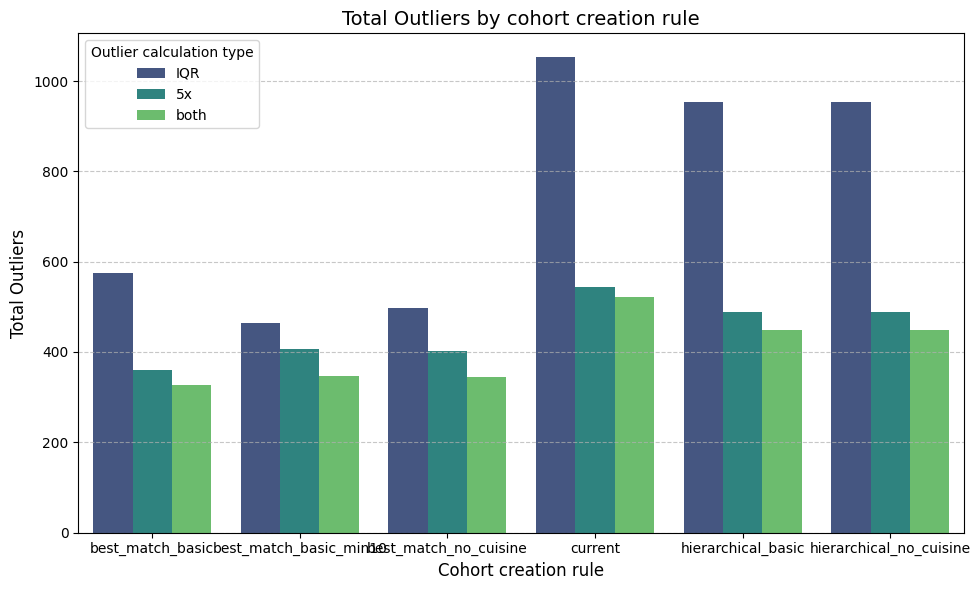

In [348]:
# Convert 'iqr_total_outliers' and 'mean_5x_total_outliers' columns to numeric, coercing errors
outlier_summary_results['iqr_total_outliers'] = pd.to_numeric(outlier_summary_results['iqr_total_outliers'], errors='coerce')
outlier_summary_results['mean_5x_total_outliers'] = pd.to_numeric(outlier_summary_results['mean_5x_total_outliers'], errors='coerce')
outlier_summary_results['overlap_total_vendors'] = pd.to_numeric(outlier_summary_results['overlap_total_vendors'], errors='coerce')

# Rename the columns for better plotting
df_melted = outlier_summary_results.rename(columns={'iqr_total_outliers': 'IQR', 'mean_5x_total_outliers': '5x', 'overlap_total_vendors' : 'both'})

# Melt the DataFrame to long format for grouped bar chart
df_melted = df_melted.melt(id_vars=['df_name'], value_vars=['IQR', '5x', 'both'], var_name='Outlier Type', value_name='Total Outliers')

plt.figure(figsize=(10, 6)) # Set the figure size for better readability

# Create the bar plot using seaborn.barplot
# x: column for the main groups (df_name)
# y: column for the bar heights (Total Outliers)
# hue: column for grouping within each x-category (Outlier Type)
sns.barplot(data=df_melted, x='df_name', y='Total Outliers', hue='Outlier Type', palette='viridis')

# Add labels and title
plt.xlabel('Cohort creation rule', fontsize=12) # X-axis label
plt.ylabel('Total Outliers', fontsize=12) # Y-axis label
plt.title('Total Outliers by cohort creation rule', fontsize=14) # Plot title
plt.legend(title='Outlier calculation type') # Add a legend with a title
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle horizontal grid
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

In [360]:
current_stats = compare_outlier_methods(df_current, 'gmv', 'cohort_id')
corrcoef = np.corrcoef(current_stats.cohort_size, current_stats.mean_5x_outliers)
print(f"The correlation between cohort size and the number of outliers in the current cohorting rule is {corrcoef[0][1]}")

The correlation between cohort size and the number of outliers in the current cohorting rule is 0.9747232442726315


In [ ]:
%%bigquery df_features_current
DECLARE REPORT_DATE date DEFAULT '2025-07-01';
DECLARE target_entities ARRAY<STRING>; 
SET target_entities = ['TB_AE'];

WITH current_cohorts AS (
   SELECT *
   FROM `logistics-vendor-production.pa_staging.smart_reco_vendor_cohorts` 
   WHERE entity_id IN UNNEST(target_entities)
)

SELECT * FROM current_cohorts

Query is running:   0%|          |

Downloading: |          |

In [410]:
df_features_current.head()

,created_date,entity_id,cohort_id,cohort_features,updated_at


In [404]:
(
    df_current
    .groupby(['cohort_id', 'cohort_features'])['vendor_code']
    .nunique()
    .sort_values(ascending=False)
    .head()
    .to_dict()
)

KeyError: 'cohort_features'

In [406]:
(
    df_best_match_basic_no_cuisine
    .groupby(['cohort_id', 'cohort_features'])['vendor_code']
    .nunique()
    .sort_values(ascending=False)
    .head()
    .to_dict()
)

{(74650,
  '{"area":"All","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"NA"}'): 1088,
 (94453,
  '{"area":"Business Bay","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 568,
 (107896,
  '{"area":"Dubai Silicon Oasis","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 405,
 (72367,
  '{"area":"All","budget":"All","city":"abu dhabi","cuisine":"All","entity":"tb_ae","vendor_grade":"NA"}'): 392,
 (128348,
  '{"area":"Jumeirah Lakes Towers - JLT","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 352}

In [407]:
(
    df_best_match_hierarchical_no_cuisine
    .groupby(['cohort_id', 'cohort_features'])['vendor_code']
    .nunique()
    .sort_values(ascending=False)
    .head()
    .to_dict()
)

{(94453,
  '{"area":"Business Bay","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 568,
 (107896,
  '{"area":"Dubai Silicon Oasis","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 405,
 (128348,
  '{"area":"Jumeirah Lakes Towers - JLT","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 352,
 (94454,
  '{"area":"Business Bay","budget":"All","city":"dubai","cuisine":"All","entity":"tb_ae","vendor_grade":"NA"}'): 327,
 (147112,
  '{"area":"Muwaileh Commercial","budget":"All","city":"sharjah","cuisine":"All","entity":"tb_ae","vendor_grade":"D"}'): 316}